In [9]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TerminateOnNaN
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import shutil

In [10]:
tf.random.set_seed(42)
np.random.seed(42)

In [24]:
def create_data_splits(test_size=0.15, val_size=0.15):
    """Create proper train/val/test splits"""
    data_dir = "E:/NTI/Garbage Classification/data/original data"
    class_names = sorted(os.listdir(data_dir))
    num_classes = len(class_names)
    
    print(f"Found {num_classes} classes: {class_names}")
    
    # Create new directory structure
    splits = ['train', 'val', 'test']
    for split in splits:
        for cls in class_names:
            os.makedirs(f'data/{split}/{cls}', exist_ok=True)
    
    # Split files for each class
    for cls in class_names:
        files = os.listdir(os.path.join(data_dir, cls))
        files = [f for f in files if f.endswith(('.jpg', '.jpeg', '.png'))]
        
        # First split: train+val vs test
        train_val_files, test_files = train_test_split(files, test_size=test_size, random_state=42)
        
        # Second split: train vs val
        train_files, val_files = train_test_split(train_val_files, test_size=val_size/(1-test_size), random_state=42)
        
        # Copy files to respective directories
        for f in train_files:
            shutil.copy2(os.path.join(data_dir, cls, f), f'data/train/{cls}/{f}')
        for f in val_files:
            shutil.copy2(os.path.join(data_dir, cls, f), f'data/val/{cls}/{f}')
        for f in test_files:
            shutil.copy2(os.path.join(data_dir, cls, f), f'data/test/{cls}/{f}')


In [25]:
def create_generators():
    """Create data generators with proper class counts"""
    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.1,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    val_test_datagen = ImageDataGenerator(rescale=1./255)
    
    train_generator = train_datagen.flow_from_directory(
        'data/train',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=True
    )
    
    val_generator = val_test_datagen.flow_from_directory(
        'data/val',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    
    test_generator = val_test_datagen.flow_from_directory(
        'data/test',
        target_size=(224, 224),
        batch_size=32,
        class_mode='categorical',
        shuffle=False
    )
    
    # Verify class counts
    print("\nClass counts:")
    print(f"Training: {train_generator.class_indices}")
    print(f"Validation: {val_generator.class_indices}")
    print(f"Test: {test_generator.class_indices}")
    
    return train_generator, val_generator, test_generator


In [26]:
def create_model(num_classes):
    """Create model with dynamic output layer"""
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
        MaxPooling2D(2, 2),
        
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Conv2D(256, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')  # Dynamic output units
    ])
    
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model

Found 10 classes: ['battery', 'biological', 'cardboard', 'clothes', 'glass', 'metal', 'paper', 'plastic', 'shoes', 'trash']
Found 13825 images belonging to 11 classes.
Found 2968 images belonging to 11 classes.
Found 2969 images belonging to 11 classes.

Class counts:
Training: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'original data': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10}
Validation: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'original data': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10}
Test: {'battery': 0, 'biological': 1, 'cardboard': 2, 'clothes': 3, 'glass': 4, 'metal': 5, 'original data': 6, 'paper': 7, 'plastic': 8, 'shoes': 9, 'trash': 10}

Train samples: 13825
Validation samples: 2968
Test samples: 2969



Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_16 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 36864)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 512)            │    18,874,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 11)             │         5,643 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,268,939 (73.51 MB)

 Trainable params: 19,268,939 (73.51 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 949ms/step - accuracy: 0.3272 - loss: 1.9642

433/433 ━━━━━━━━━━━━━━━━━━━━ 440s 1s/step - accuracy: 0.3274 - loss: 1.9638 - val_accuracy: 0.5172 - val_loss: 1.4168
Epoch 2/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 788ms/step - accuracy: 0.4886 - loss: 1.4966

433/433 ━━━━━━━━━━━━━━━━━━━━ 357s 823ms/step - accuracy: 0.4886 - loss: 1.4965 - val_accuracy: 0.5758 - val_loss: 1.2280
Epoch 3/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 784ms/step - accuracy: 0.5586 - loss: 1.2897

433/433 ━━━━━━━━━━━━━━━━━━━━ 354s 818ms/step - accuracy: 0.5586 - loss: 1.2897 - val_accuracy: 0.6038 - val_loss: 1.1649
Epoch 4/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 782ms/step - accuracy: 0.5848 - loss: 1.2191

433/433 ━━━━━━━━━━━━━━━━━━━━ 354s 817ms/step - accuracy: 0.5848 - loss: 1.2191 - val_accuracy: 0.6314 - val_loss: 1.0869
Epoch 5/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 353s 815ms/step - accuracy: 0.6169 - loss: 1.1368 - val_accuracy: 0.6297 - val_loss: 1.0983
Epoch 6/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 783ms/step - accuracy: 0.6384 - loss: 1.0662

433/433 ━━━━━━━━━━━━━━━━━━━━ 354s 817ms/step - accuracy: 0.6384 - loss: 1.0662 - val_accuracy: 0.6840 - val_loss: 0.9557
Epoch 7/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 780ms/step - accuracy: 0.6534 - loss: 1.0195

433/433 ━━━━━━━━━━━━━━━━━━━━ 353s 814ms/step - accuracy: 0.6534 - loss: 1.0195 - val_accuracy: 0.6920 - val_loss: 0.9189
Epoch 8/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 353s 815ms/step - accuracy: 0.6733 - loss: 0.9668 - val_accuracy: 0.6867 - val_loss: 0.9474
Epoch 9/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 779ms/step - accuracy: 0.6833 - loss: 0.9488

433/433 ━━━━━━━━━━━━━━━━━━━━ 353s 814ms/step - accuracy: 0.6833 - loss: 0.9488 - val_accuracy: 0.7011 - val_loss: 0.9314
Epoch 10/10
433/433 ━━━━━━━━━━━━━━━━━━━━ 0s 808ms/step - accuracy: 0.6979 - loss: 0.9010

433/433 ━━━━━━━━━━━━━━━━━━━━ 366s 844ms/step - accuracy: 0.6979 - loss: 0.9010 - val_accuracy: 0.7193 - val_loss: 0.8632


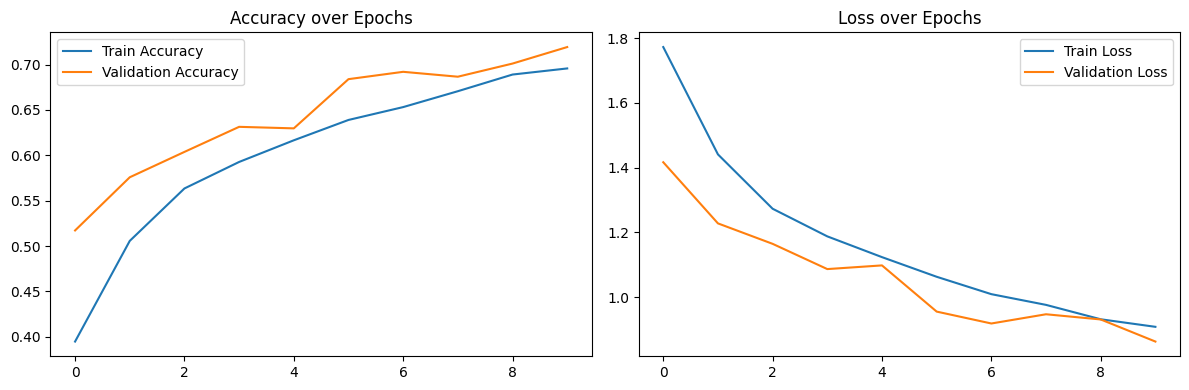

93/93 ━━━━━━━━━━━━━━━━━━━━ 31s 336ms/step - accuracy: 0.7885 - loss: 0.7029

Test Accuracy: 0.7440
Test Loss: 0.7855


In [28]:
def main():
    # Create proper data splits
    create_data_splits()
    
    # Create generators and get actual class count
    train_gen, val_gen, test_gen = create_generators()
    num_classes = len(train_gen.class_indices)
    
    # Verify data
    print(f"\nTrain samples: {train_gen.samples}")
    print(f"Validation samples: {val_gen.samples}")
    print(f"Test samples: {test_gen.samples}\n")
    
    # Create model with correct output shape
    model = create_model(num_classes)
    model.summary()
    
    # Callbacks
    callbacks = [
        EarlyStopping(patience=5, restore_best_weights=True, monitor='val_accuracy'),
        ModelCheckpoint('models/best_model.h5', save_best_only=True, monitor='val_accuracy'),
        TerminateOnNaN()
    ]
    
    # Train
    history = model.fit(
        train_gen,
        epochs=10,
        validation_data=val_gen,
        callbacks=callbacks
    )
    
    # Save and evaluate
    model.save('models/final_model.h5')
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Evaluate
    test_loss, test_acc = model.evaluate(test_gen)
    print(f"\nTest Accuracy: {test_acc:.4f}")
    print(f"Test Loss: {test_loss:.4f}")

if __name__ == '__main__':
    main()